In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import tree

### 실습 과제 1. 데이터 불러온 후 종속변수 데이터 타입 변경, train_data : test_data = 8:2 split, random_state=1000
#### 종속변수는 'class', 독립변수는 나머지 변수

In [3]:
df = pd.read_csv('Hepatitis.csv')
df.head()

,age,sex,steriod,antivirals,fatigue,mamaise,anorexia,liver big,liver firm,spleen palpable,spiders,ascites,varices,bilirubin,alk phosphate,sgot,albumin,protime,histology,class
0,39,1,1,1,1,1,2,2,1,2,2,2,2,2.3,280,98,3.8,40,1,1
1,59,1,1,2,1,1,2,2,1,1,1,2,2,1.5,107,157,3.6,38,2,1
2,47,1,2,2,2,2,2,2,2,2,1,2,1,2.0,84,23,4.2,66,2,1
3,48,1,1,2,1,1,2,2,1,2,1,1,1,4.8,123,157,2.7,31,2,1
4,47,1,2,2,1,1,2,2,1,2,2,1,1,1.7,86,20,2.1,46,2,1


In [6]:
df = df.astype({'class':str})
df.dtypes

age                  int64
sex                  int64
steriod              int64
antivirals           int64
fatigue              int64
mamaise              int64
anorexia             int64
liver big            int64
liver firm           int64
spleen palpable      int64
spiders              int64
ascites              int64
varices              int64
bilirubin          float64
alk phosphate        int64
sgot                 int64
albumin            float64
protime              int64
histology            int64
class               object
dtype: object

In [7]:
Input = df.drop('class', axis = 1)
Output = df.loc[:, 'class']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Input, Output, test_size = 0.2, random_state = 1000)

print('train data : ', X_train.shape)
print('test data : ', X_test.shape)

train data :  (64, 19)
test data :  (16, 19)


### 실습2: 5-fold cross validation을 이용해 최적의 하이퍼파라미터를 구하고, test set에 대한 최적 모델의 예측 정확도 구하기
####  하이퍼 파라미터 : max_depth:[2,4,6], min_samples_split: [2,3,4]

In [12]:
from sklearn import tree

dtree = tree.DecisionTreeClassifier()

In [13]:
from sklearn.model_selection import GridSearchCV

hyparams = {'max_depth':[2,4,6], 'min_samples_split': [2,3,4]}

grid_cv = GridSearchCV(dtree, param_grid = hyparams, cv = 5, scoring = 'accuracy', return_train_score = True)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'min_samples_split': [2, 3, 4]},
             return_train_score=True, scoring='accuracy')

In [15]:
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

cv_results_df[['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'mean_train_score']]

,param_max_depth,param_min_samples_split,mean_test_score,mean_train_score
0,2,2,0.796154,0.953092
1,2,3,0.844872,0.953092
2,2,4,0.814103,0.953092
3,4,2,0.811538,0.996154
4,4,3,0.780769,0.992232
5,4,4,0.814103,0.988311
6,6,2,0.796154,1.000000
7,6,3,0.814103,0.996078
8,6,4,0.796154,0.988311


In [16]:
print(f'최고 평균 정확도 : {grid_cv.best_score_}, 최적 하이퍼 파라미터 : {grid_cv.best_params_}')

최고 평균 정확도 : 0.8448717948717949, 최적 하이퍼 파라미터 : {'max_depth': 2, 'min_samples_split': 3}


In [18]:
best_dtree = grid_cv.best_estimator_
best_y_pred = best_dtree.predict(X_test)
best_accuracy = metrics.accuracy_score(y_test, best_y_pred)

print('best 예측 정확도 :', best_accuracy)

best 예측 정확도 : 0.875


### 실습 3: 최적 트리 모델 이미지 출력하기 (이미지에 변수 이름과 class가 모두 있어야 함), feature importance barplot 출력

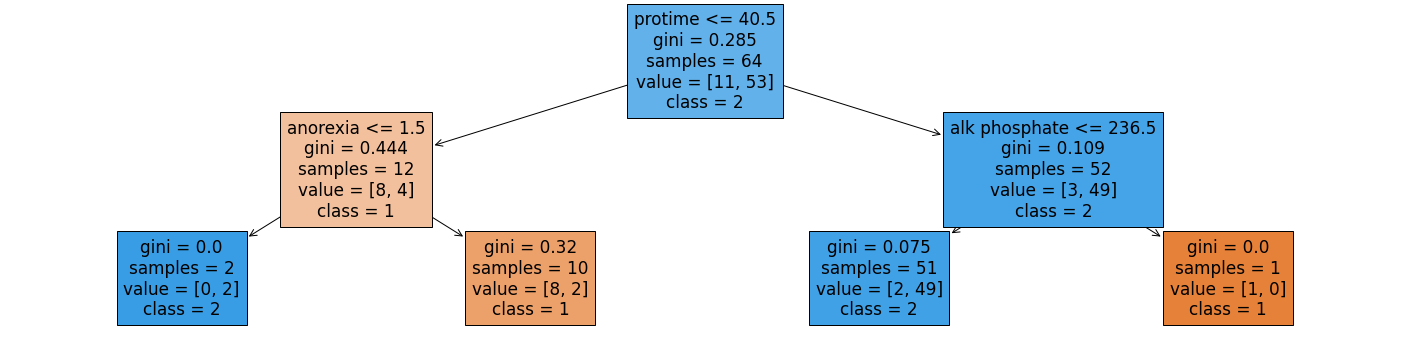

In [29]:
var_names = X_train.columns
class_names = best_dtree.classes_

plt.figure(figsize=(25,6))
tree.plot_tree(best_dtree,
              feature_names = var_names,
              class_names = class_names,
              filled = True)
plt.show()

In [26]:
feature_importance_values = best_dtree.feature_importances_
feature_importance_values_s = pd.Series(feature_importance_values, index = X_train.columns)

feature_importance_sort = feature_importance_values_s.sort_values(ascending=False)

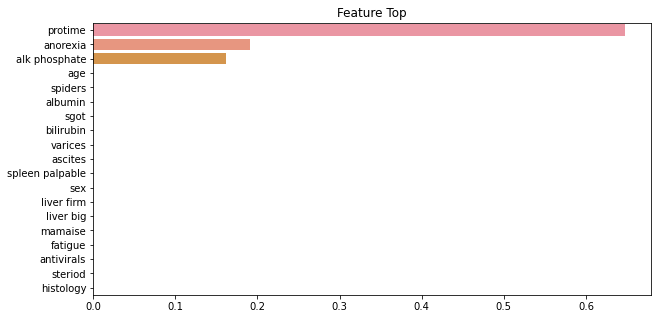

In [27]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.title('Feature Top')
sns.barplot(x=feature_importance_sort, y=feature_importance_sort.index)
plt.show()

### 실습 4: 최적 트리 모델을 post-pruning하고, post-pruning된 트리 모델 출력(이미지에 변수 이름과 class가 모두 있어야 함)
#### (test accuracy가 높으면서, node개수와 tree depth가 작은 alpha를 찾고, 해당 alpha에 해당하는 트리 모델 출력하는 실습 )

In [30]:
path = best_dtree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas)
print(impurities)

[0.         0.02829233 0.03333333 0.11299329]
[0.11004902 0.13834135 0.17167468 0.28466797]


In [32]:
dtree_list = []
for ccp_alpha in ccp_alphas:
    dtree_alpha = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dtree_alpha.fit(X_train, y_train)
    dtree_list.append(dtree_alpha)

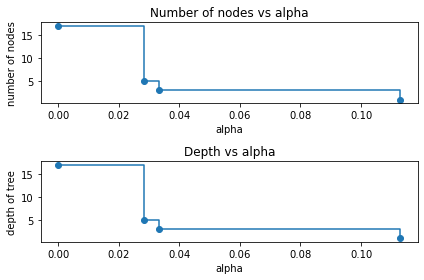

In [34]:
node_counts = [tree_alpha.tree_.node_count
              for tree_alpha in dtree_list]
depth = [tree_alpha.tree_.max_depth
        for tree_alpha in dtree_list]

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()
plt.show()

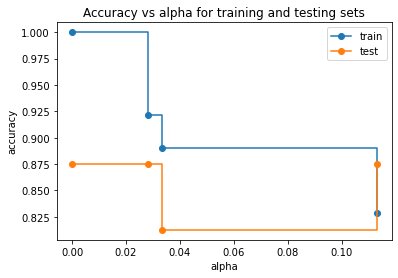

In [36]:
train_scores = [tree_alpha.score(X_train, y_train) for tree_alpha in dtree_list]
test_scores = [tree_alpha.score(X_test, y_test) for tree_alpha in dtree_list]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Index(['age', 'sex', 'steriod', 'antivirals', 'fatigue', 'mamaise', 'anorexia',
       'liver big', 'liver firm', 'spleen palpable', 'spiders', 'ascites',
       'varices', 'bilirubin', 'alk phosphate', 'sgot', 'albumin', 'protime',
       'histology'],
      dtype='object')
['1' '2']


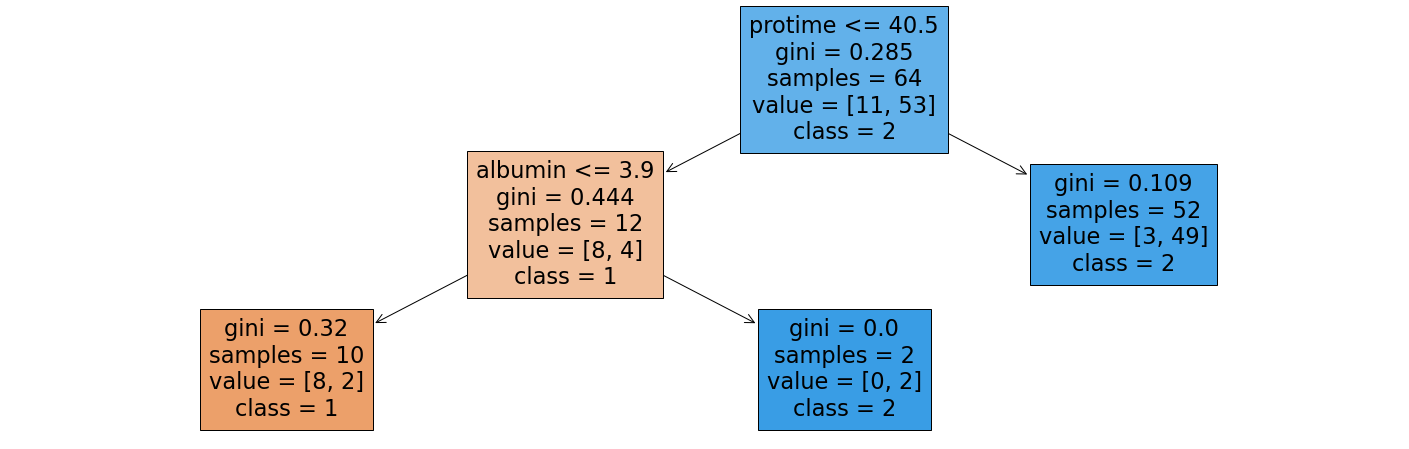

In [37]:
var_names = X_train.columns
print(var_names)

class_names = dtree_list[1].classes_
print(class_names)

plt.figure(figsize=(25,8))
tree.plot_tree(dtree_list[1],
              feature_names=var_names,
              class_names=class_names,
              filled=True)
plt.show()